In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [7]:
shot_path = 'laser_shots'

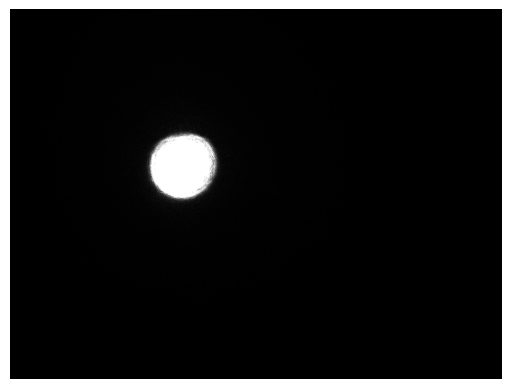

In [6]:
test = cv.imread('../laser_shots/2h_2000us.png', cv.IMREAD_GRAYSCALE)
# print(test.shape)
plt.axis('off')
plt.imshow(test, cmap='gray')

In [8]:
def filter_bright_range(img: np.ndarray, threshold: int = 100) -> np.ndarray:
    bright_pixels = img > threshold
    # get smallest and largest indices of bright pixels, both in x and y direction
    x_min, x_max = np.min(np.where(bright_pixels)[0]), np.max(np.where(bright_pixels)[0])
    y_min, y_max = np.min(np.where(bright_pixels)[1]), np.max(np.where(bright_pixels)[1])
    return img[x_min:x_max, y_min:y_max]

In [10]:
filtered_imgs = []
for i in range(2, 14):
    img = cv.imread(f'../laser_shots/{i}h_2000us.png', cv.IMREAD_GRAYSCALE)
    filtered_imgs.append(filter_bright_range(img))

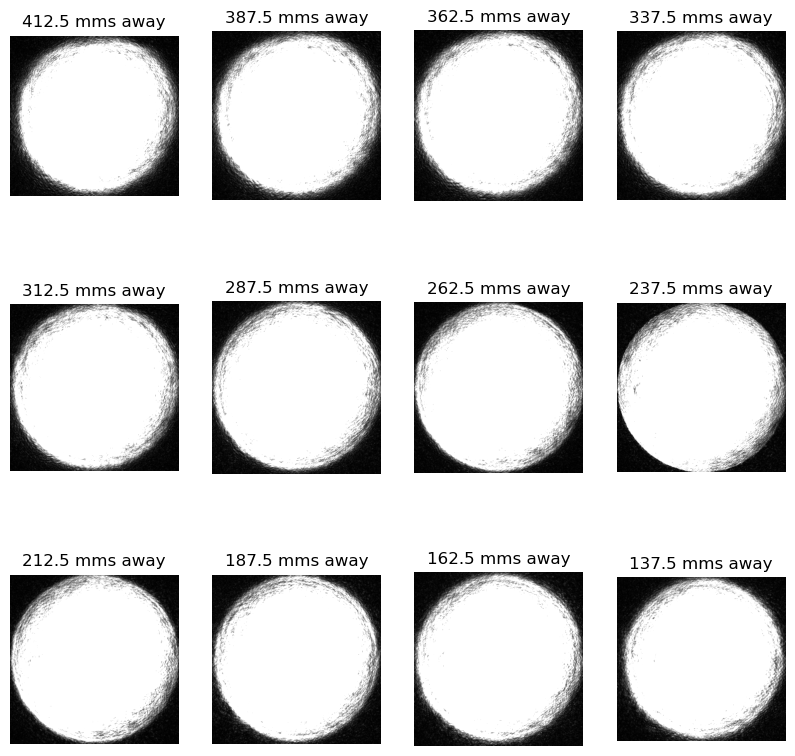

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.axis('off')
    ax.imshow(filtered_imgs[i], cmap='gray')
# set x and y labels
for ax, label in zip(axs.flat, range(2, 14)):
    ax.set_title(f'{(18.5 - label) * 25} mms away')
plt.show()